### Import dataset


In [48]:
import deeplake
from deeplake import Dataset

ds: Dataset = deeplake.load("hub://activeloop/icdar-2013-text-localize-train")

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/icdar-2013-text-localize-train



\

hub://activeloop/icdar-2013-text-localize-train loaded successfully.



### Noise Removal


In [56]:
from skimage.color import rgb2gray
from random import randint
from skimage.io import imsave, imread
from plots import plot

idx = randint(0, 230)
img = imread("./og1.png")
# img = imread("./og3.png", as_gray=True)
# print(img.shape, img2.shape)
# img = rgb2gray(ds.images[idx].numpy())

### Stroke Width Transform


#### Stroke Width Transform


total 7.517755508422852
0.8209969997406006 5.514792203903198 1.1819663047790527
10.92077281338506 73.35689751714399 15.722329669470952


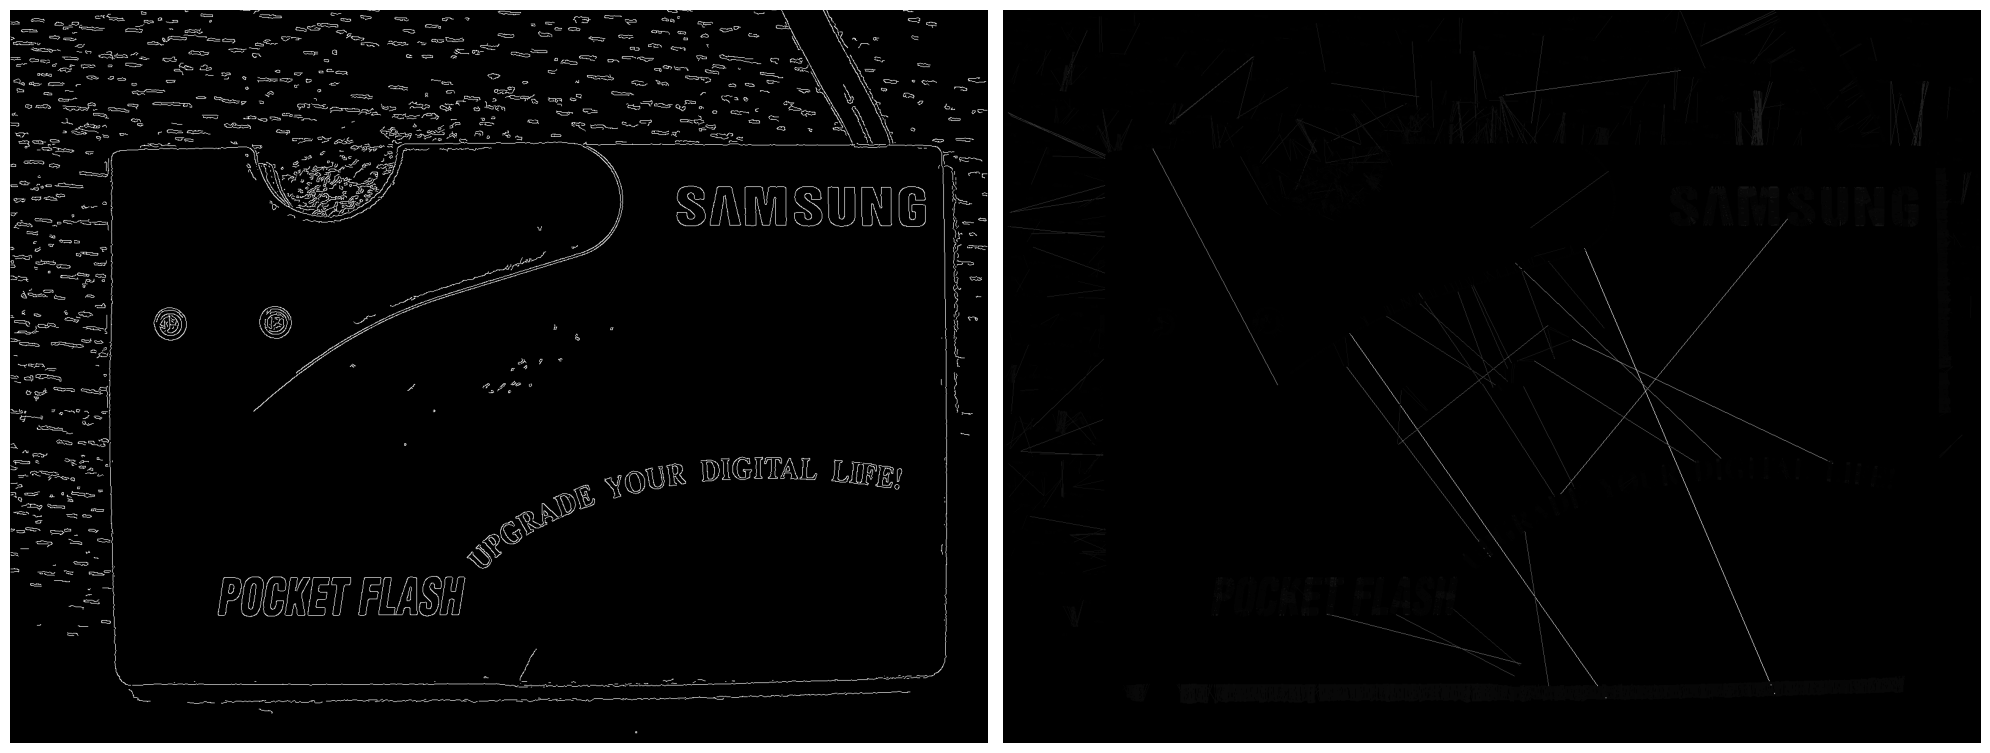

In [75]:
from skimage.draw import line as skline
from math import floor
from skimage.filters import scharr_h, scharr_v
import numpy as np
from skimage.feature import canny
import time
from itertools import islice

der_t = None
swt_edge_loop_t = None
project_avg_t = None
traverse_avg_t = None
swt_ray_loop_t = None


def derivatives(img, grad_dir=-1):
    # edge_map and x, y gradients and angles
    t0 = time.time()
    grads = (scharr_h(img), scharr_v(img))
    angles = np.arctan2(grads[1] * grad_dir, grads[0] * grad_dir)
    edges = canny(img)
    global der_t
    der_t = time.time() - t0

    return edges, grads, angles


def project_ray(diag, start, angles):
    # Calculate the end point of the line
    end_x = floor(start[0] + diag * np.cos(angles[start]))
    end_y = floor(start[1] + diag * np.sin(angles[start]))

    return zip(*skline(start[0], start[1], end_x, end_y))


def traverse_line(line, dims, edge_map):
    # track if endpoint is found
    end = None

    height, width = dims
    # skip the current position
    line = islice(line, 1, None)

    for r, c in line:
        # out of bounds check
        if not (0 <= r < height and 0 <= c < width):
            break

        # other edge found
        if edge_map[r, c] == 1:
            end = (r, c)
            break

    return end


def angle_between(start, end, gradients):
    # x, y gradients at the start and end points
    v1 = (gradients[0][start], gradients[1][start])
    v2 = (gradients[0][end] * -1, gradients[1][end] * -1)
    # np.negative(v2, out=v2)

    # determine angle by using the formula for the dot product
    dotmag = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    # range of arccos is [0, pi]
    return np.arccos(dotmag)


def plot_new_line(img, start, end):
    # calculate the distance between the edge point and the endpoint
    # distance = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
    distance = np.hypot(end[0] - start[0], end[1] - start[1])
    line = skline(start[0], start[1], end[0], end[1])

    # Update pixels that belong to the new line with the minimum distance
    img[line] = np.minimum(img[line], distance)
    # np.minimum(img[line], distance, out=img[line])

    return line


def swt(img, edge_map, gradients, angles):
    # Output image
    projection = np.ones(img.shape) * np.Infinity

    # collection of rays
    rays = []

    # image dimensions
    dims = (img.shape[0], img.shape[1])

    # diagonal of image for initial line projection length
    # diaglen = np.sqrt(dims[0] ** 2 + dims[1] ** 2)
    diaglen = np.linalg.norm(dims)

    t_outer0 = time.time()
    project_t = []
    traverse_t = []
    # loop the edges in the edge map
    for edge_x, edge_y in np.argwhere(edge_map == 1):

        start = edge_x, edge_y

        t0 = time.time()
        # project a line from the edge point in the direction of the gradient
        ray = project_ray(diaglen, start, angles)

        project_t.append(time.time() - t0)

        t0 = time.time()

        # track if endpoint is found
        end = traverse_line(ray, dims, edge_map)

        traverse_t.append(time.time() - t0)

        if end is None:
            continue

        # lines that are not roughly opposite are discarded
        if angle_between(start, end, gradients) > np.pi / 4:
            continue

        # plot the new line
        new_ray = plot_new_line(projection, start, end)
        rays.append(new_ray)

    global project_avg_t
    project_avg_t = np.mean(project_t)

    global traverse_avg_t
    traverse_avg_t = np.mean(traverse_t)

    global swt_edge_loop_t
    swt_edge_loop_t = time.time() - t_outer0

    # set all the upper bounds back to 0
    projection[projection == np.Infinity] = 0

    t0 = time.time()

    medians = [np.median(projection[ray]) for ray in rays]

    for ray, median in zip(rays, medians):
        np.minimum(projection[ray], median, out=projection[ray])

    global swt_ray_loop_t
    swt_ray_loop_t = time.time() - t0
    return rays, projection


edge_map, grads, angles = derivatives(img, -1)
rays, swt_result = swt(img, edge_map, grads, angles)
total = der_t + swt_edge_loop_t + swt_ray_loop_t
print("total", total)

print(der_t, swt_edge_loop_t, swt_ray_loop_t)
print(
    100 * der_t / total,
    100 * swt_edge_loop_t / total,
    100 * swt_ray_loop_t / total,
)

plot([edge_map, swt_result])

#### Removing Outliers


In [52]:
# from skimage import draw, filters, img_as_float


# def remove_outliers_swt(swt):
#     filtered = np.copy(swt)
#     vals = swt[swt > 0]
#     q1 = np.percentile(vals, 25)
#     q3 = np.percentile(vals, 75)
#     iqr = q3 - q1
#     lower_bound = q1 - (2 * iqr)
#     upper_bound = q3 + (2 * iqr)

#     filtered[swt > upper_bound] = 0
#     filtered[swt < lower_bound] = 0

#     return filtered


# og_swt_filtered = og_swt
# new_swt_filtered = remove_outliers_swt(new_swt)
# plot(
#     [og_swt_filtered, new_swt_filtered],
#     titles=["Stroke Width Transform", "SWT without Outliers"],
# )

### Connected Components


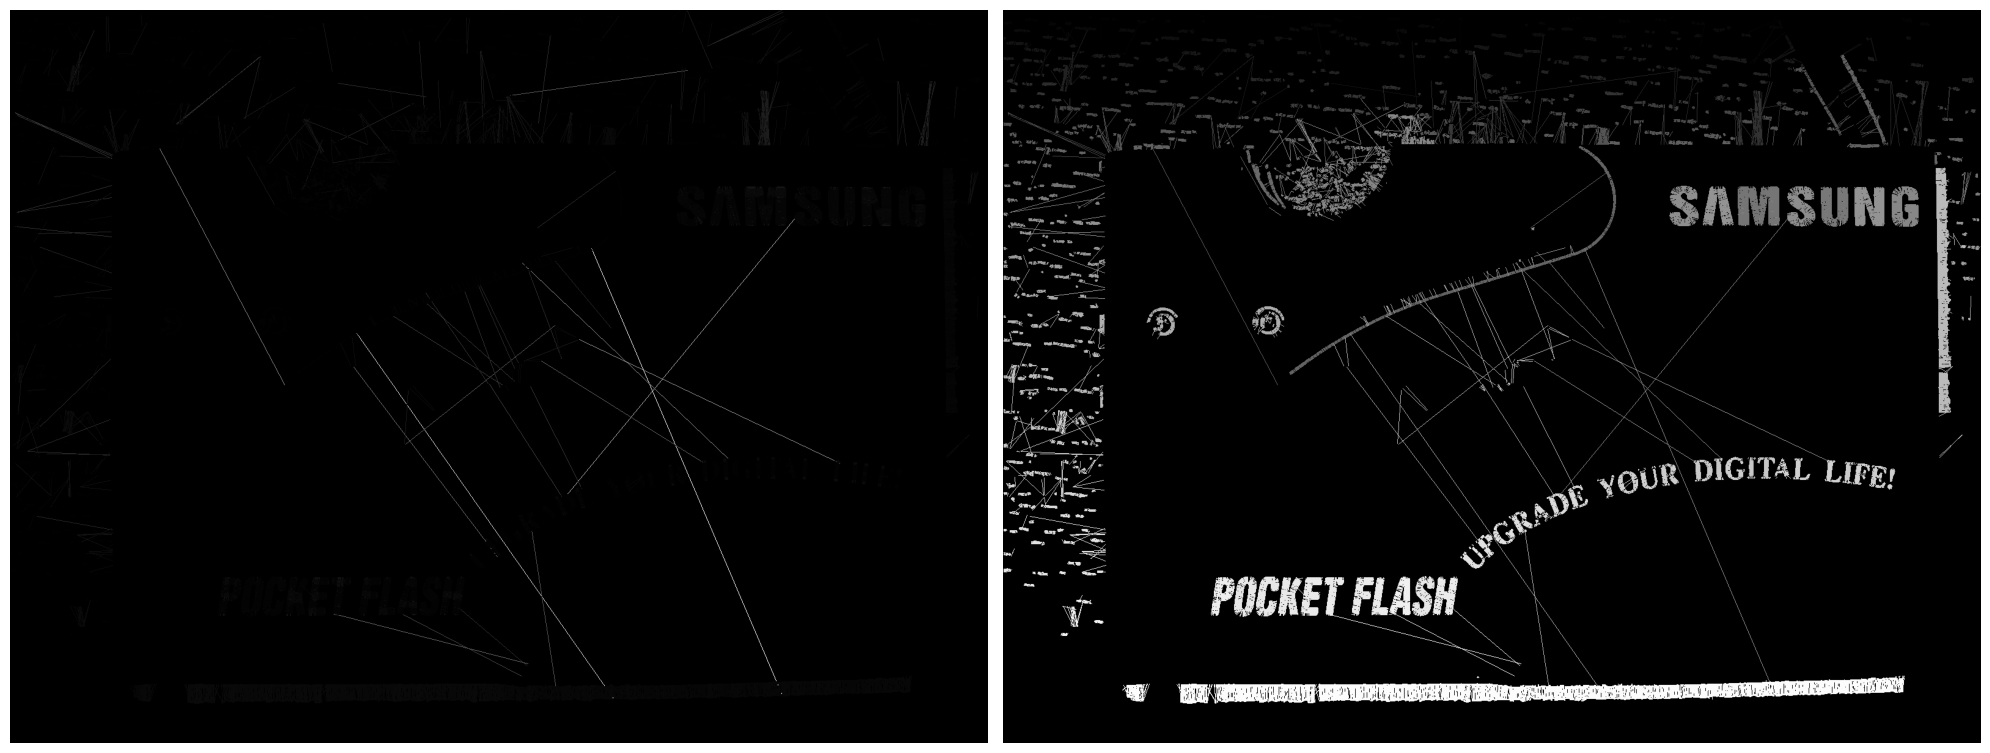

In [70]:
def store_equivalent_labels(eq_labels: dict, label1: int, label2: int):
    # Find the root labels for the two labels
    root1 = label1
    while eq_labels.get(root1, None) is not None:
        root1 = eq_labels[root1]
    root2 = label2
    while eq_labels.get(root2, None) is not None:
        root2 = eq_labels[root2]

    # Store the equivalence relationship
    if root1 != root2:
        eq_labels[root2] = root1


def connected_components(swt_img):
    label = 0
    labels = np.zeros(swt_img.shape, dtype=np.int32)
    eq_labels = {}

    def valid_neighbors(idx):
        # neighbors iterator for 8-connectivity
        def neighbors(idx):
            i, j = idx
            for x in range(i - 2, i + 3):
                for y in range(j - 2, j + 3):
                    if (x, y) != (i, j):
                        yield x, y
            # yield i - 1, j
            # yield i - 1, j - 1
            # yield i - 1, j + 1
            # yield i + 1, j
            # yield i + 1, j - 1
            # yield i + 1, j + 1
            # yield i, j - 1
            # yield i, j + 1

        # return an array of indices of valid neighbors
        # for each possible neighbor of the edge pixel at idx
        # it is a possible neightbor if it is an edge pixel
        # we check if the label
        # return [labels[p] for p in neighbors(idx) if edges[p] and labels[p]]
        return [
            labels[p]
            for p in neighbors(idx)
            if p[0] < labels.shape[0]
            and p[1] < labels.shape[1]
            and swt_img[p] > 0
            and labels[p] != 0
            and ((swt_img[idx] / swt_img[p]) < 3)
            and ((swt_img[p] / swt_img[idx]) < 3)
        ]

    for edge_idx in np.argwhere(swt_img != 0):
        i, j = edge_idx

        # get the label values of the valid neighbors of the current point
        neighs = valid_neighbors((i, j))

        # if no neighbors, create a new label
        if not neighs:
            label += 1
            labels[i, j] = label
            continue

        # if one or more neighbor, assign the current point that label
        labels[i, j] = neighs[0]

        # store all labels as equivalent
        for n in neighs[1:]:
            store_equivalent_labels(eq_labels, neighs[0], n)

    # replace all labels with their root labels
    for i, j in np.argwhere(labels != 0):
        root = labels[i, j]
        while eq_labels.get(root, None) is not None:
            root = eq_labels[root]
        labels[i, j] = root

    unique = np.unique(labels)
    component_dict = {l: [] for l in unique if l != 0}

    for index, value in np.ndenumerate(labels):
        if value != 0:
            component_dict[value].append(index)

    return component_dict, labels


def remove_high_variance_components(comp_dict, swt_img, swt_labeled):
    swt_img_cpy = swt_img.copy()
    labeled_cpy = swt_labeled.copy()
    mod_comp_dict = {}

    # for each collection of pixels identified as a component stored as key: [idx, idx, idx...]
    for k, v in comp_dict.items():
        swt_vals = [swt_img_cpy[i] for i in v]
        avg_swt = np.mean(swt_vals)

        if np.var(swt_vals) < avg_swt / 2:
            mod_comp_dict[k] = v
        else:
            for i in v:
                swt_img_cpy[i] = 0
                labeled_cpy[i] = 0

    return mod_comp_dict, labeled_cpy, swt_img_cpy


component_dict, label_img = connected_components(swt_result)

# mod_comp_dict, mod_label_img, mod_swt_img = remove_high_variance_components(
#     component_dict, swt_result, label_img
# )


# for k, v in component_dict.items():
#     print(k, np.var(v))

plot([swt_result, label_img])

#### Remove Sparse Components


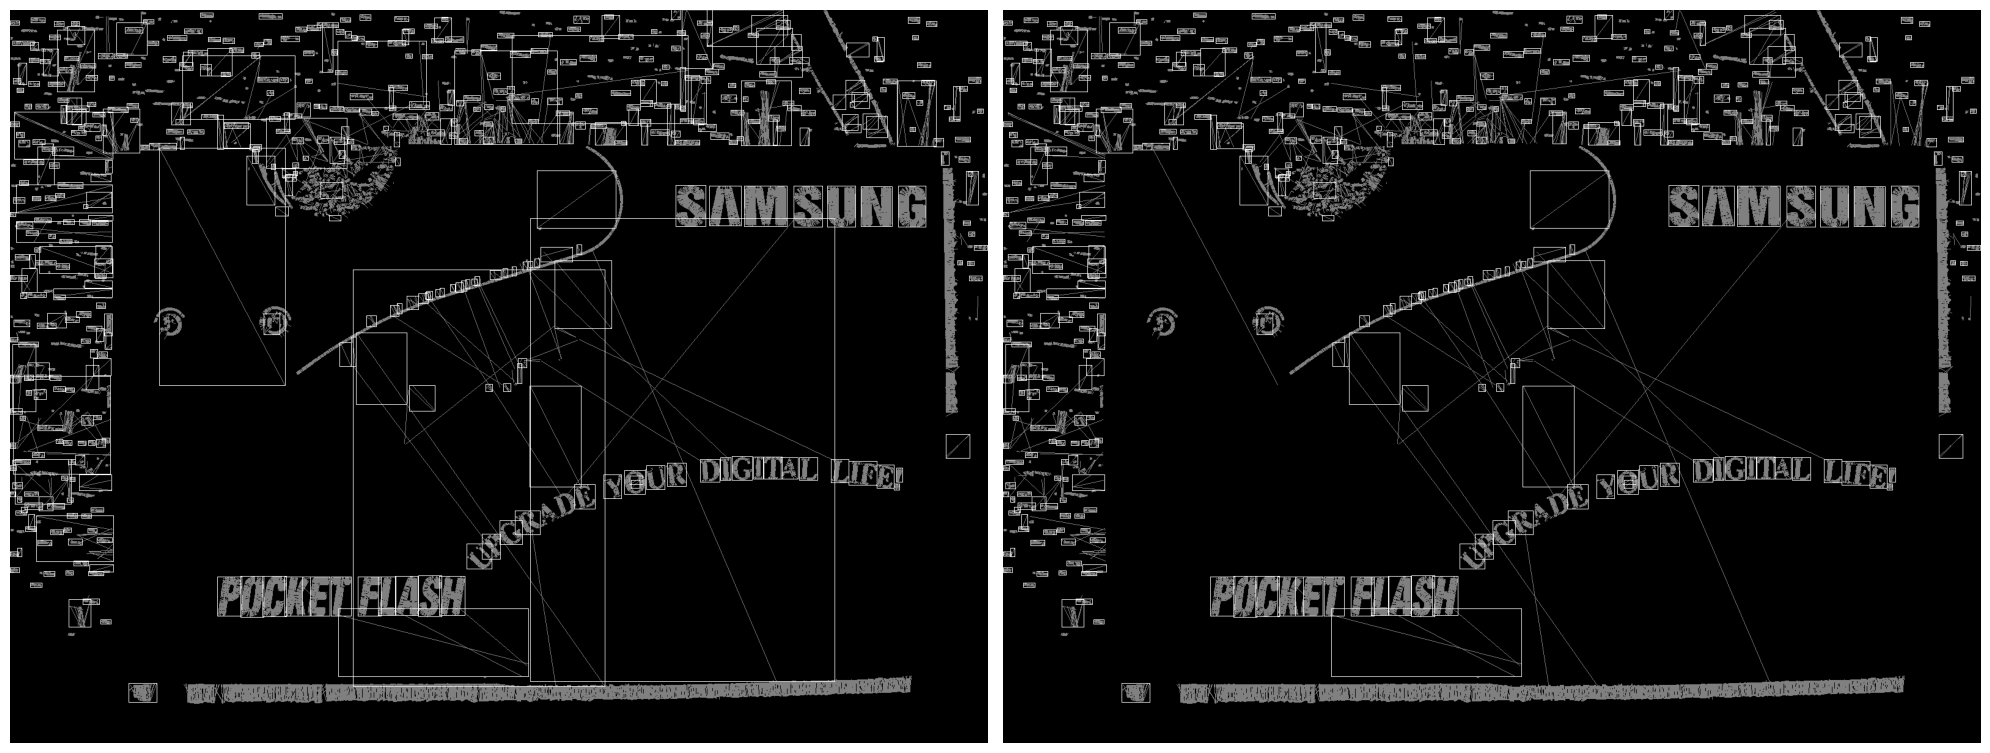

In [55]:
from skimage import draw


def bounding_boxes(connected):

    boxes = []

    for _, indices in connected.items():

        xs = [i[0] for i in indices]

        ys = [i[1] for i in indices]

        xmin, xmax = np.min(xs), np.max(xs)

        ymin, ymax = np.min(ys), np.max(ys)

        xdim, ydim = xmax - xmin, ymax - ymin

        if xdim < 5 or ydim < 5:

            continue

        if (xdim / ydim) < 0.1 or (xdim / ydim) > 10:

            continue

        diameter = np.sqrt(xdim**2 + ydim**2)
        component = [swt_result[i] for i in indices]
        median = np.median(component)

        if diameter / median > 10:
            continue

        # area = xdim * ydim

        # if len(indices) / area < 0.1:

        #     continue

        boxes.append((xmin, ymin, xmax, ymax))

    return boxes


def draw_boxes(img, boxes):

    img_cpy = np.zeros(img.shape)

    img_cpy[swt_result > 0] = 1

    for box in boxes:

        xmin, ymin, xmax, ymax = box

        rr, cc = draw.rectangle_perimeter((xmin, ymin), (xmax, ymax))

        img_cpy[rr, cc] = 2

    return img_cpy


def id_text(img, boxes):

    img_cpy = np.zeros(img.shape)

    for box in boxes:

        xmin, ymin, xmax, ymax = box

        rr, cc = draw.rectangle((xmin, ymin), (xmax, ymax))

        img_cpy[rr, cc] = img[rr, cc]

    return img_cpy


boxes = bounding_boxes(component_dict)


def is_inside(box1, box2):

    x1min, y1min, x1max, y1max = box1

    x2min, y2min, x2max, y2max = box2

    return x1min >= x2min and y1min >= y2min and x1max <= x2max and y1max <= y2max


box_counts = {i: 0 for i in range(len(boxes))}


for i, box1 in enumerate(boxes):

    for j, box2 in enumerate(boxes):

        if i != j and is_inside(box2, box1):

            box_counts[i] += 1


filtered_boxes = [box for i, box in enumerate(boxes) if box_counts[i] <= 2]


# boxes = sorted(boxes, key=box_predicate)


# plot([img, draw_boxes(img, boxes), id_text(img, boxes)])


plot([draw_boxes(img, boxes), draw_boxes(img, filtered_boxes)])